### Load a FaceNet Model in Keras

In [1]:
# example of loading the keras facenet model
from keras.models import load_model
import matplotlib.pyplot as plt
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


### Develop a Face Classification System

In [2]:
import numpy as np
b = np.load('5-celebrity-faces-dataset.npz')
print(b.files)
X_train = b['arr_0']
Y_train = b['arr_1']
print(f'X_train Size : {X_train.shape}')
print(f'Y_train Size : {Y_train.shape}')
X_val = b['arr_2']
Y_val = b['arr_3']
print(f'X_val Size : {X_val.shape}')
print(f'Y_val Size : {Y_val.shape}')

['arr_0', 'arr_1', 'arr_2', 'arr_3']
X_train Size : (93, 160, 160, 3)
Y_train Size : (93,)
X_val Size : (25, 160, 160, 3)
Y_val Size : (25,)


### Visualization

In [3]:
Y_train

array(['ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek',
       'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek',
       'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek',
       'ben_afflek', 'ben_afflek', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'madonna', 'madonna',
       'madonna', 'madonna', 'madonna', 'madonna', 'madonna',

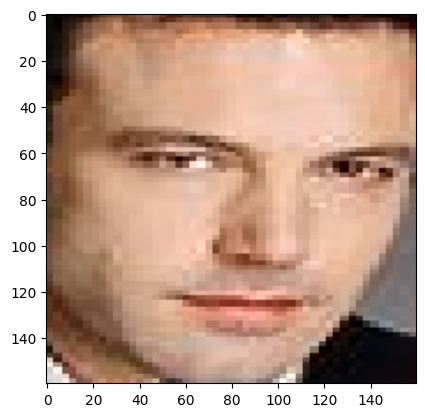

In [4]:
plt.imshow(X_train[5])

### Create Face Embeddings

In [5]:
# normalize the train and test samples face images
X_train_norm = np.zeros(X_train.shape)
for index, face in enumerate(X_train):
    face_pixels = face.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    X_train_norm[index] = (face_pixels - mean) / std
    
X_val_norm = np.zeros(X_val.shape)
for index, face in enumerate(X_val):
    face_pixels = face.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    X_val_norm[index] = (face_pixels - mean) / std

In [6]:
X_train_embedings = model.predict(X_train_norm)
X_val_embedings = model.predict(X_val_norm)
print(f'X_train_embedings : {X_train_embedings.shape}')
print(f'X_val_embedings : {X_val_embedings.shape}')

1/1 [==============================] - 0s 482ms/step
X_train_embedings : (93, 128)
X_val_embedings : (25, 128)


### Perform Face Classification

In [7]:
from sklearn.preprocessing import Normalizer
# normalize input embeding vectors
transformer = Normalizer(norm='l2')
X_train_emb_norm = transformer.transform(X_train_embedings)
X_val_emb_norm = transformer.transform(X_val_embedings)

### how does sklearn normalize the embedings?
If you square each value in the output and then add them together, the result is 1, or very close to 1.

In [8]:
np.linalg.norm(X_train_embedings[0])

12.53065

In [9]:
np.linalg.norm(X_train_emb_norm[0])

1.0

In [10]:
from sklearn.preprocessing import LabelEncoder

# label encode targets
le = LabelEncoder()
le.fit(Y_train)
Y_train_norm = le.transform(Y_train)
Y_val_norm = le.transform(Y_val)

In [11]:
Y_train_norm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4])

In [12]:
from sklearn.svm import SVC
# fit model
SVM_model = SVC(kernel='linear', probability=True)
SVM_model.fit(X_train_emb_norm, Y_train_norm)

SVC(kernel='linear', probability=True)

In [13]:
X_train_emb_norm.shape

(93, 128)

In [14]:
X_val_emb_norm.shape

(25, 128)

In [15]:
from sklearn.metrics import accuracy_score
# predict
yhat_train = SVM_model.predict(X_train_emb_norm)
yhat_val = SVM_model.predict(X_val_emb_norm)
# score
score_train = accuracy_score(Y_train_norm, yhat_train)
score_val = accuracy_score(Y_val_norm, yhat_val)
# summarize
print('Accuracy: train=%.3f, validation=%.3f' % (score_train*100, score_val*100))

Accuracy: train=98.925, validation=100.000


## Another method based on vector similarity (Cosine and Simple)

In [16]:
#cosine similarity for use in visualization
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    magnitude_A = np.linalg.norm(A)
    magnitude_B = np.linalg.norm(B)
    cosine_similarity = dot_product / (magnitude_A * magnitude_B)
    return cosine_similarity

In [17]:
#people names in the dataset
people = ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

In [18]:
#create a list of cosine value and simple embedings of same individuals
cosine_similarities = []
simple_similarities = []

#person in ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
for person in people:
    #index in [0 to 13], [14 to 30], [31 to 51], [52 to 70], [71 to 92]
    index = np.where(Y_train == person)[0]
    #X_temp in embedings with shape (14, 128), (17, 128), (21, 128), (19, 128), (22, 128)
    X_temp = X_train_embedings[index]
    
    #emb shape is (128,) itterate in X_temp(X_temp is X_train[individual])
    for cnt, emb in enumerate(X_temp):
        
        if len(X_temp)-cnt-1 != 0:
            #itterate based on factoriel of X_temp length
            for i in range(len(X_temp)-cnt-1):
                cosine_similarities.append(cosine_similarity(emb, X_temp[cnt+i+1]))
                simple_similarities.append(emb - X_temp[cnt+i+1])
                
print(f'length cosine_similarities : {len(cosine_similarities)} --> shape{np.array(cosine_similarities).shape}')
print(f'length simple_similarities : {len(simple_similarities)} --> shape{np.array(simple_similarities).shape}')


length cosine_similarities : 839 --> shape(839,)
length simple_similarities : 839 --> shape(839, 128)


In [19]:
#create a list of cosine value and simple embedings of different individuals
cosine_differences = []
simple_differences= []
for cnt, person in enumerate(people):
    #person_1 itterate on people names
    person_1 = person
    index_1 = np.where(Y_train == person_1)[0]
    #X_temp in embedings with shape (14, 128), (17, 128), (21, 128), (19, 128), (22, 128)
    X_temp_1 = X_train_embedings[index_1]
    if cnt+1 != len(people):
        
        for i in range(cnt+1, len(people)):
            #person_2 itterate on people names unless person_1 name and all before it
            person_2 = people[i]
            index_2 = np.where(Y_train == person_2)[0]
            #X_temp in embedings with shape (14, 128), (17, 128), (21, 128), (19, 128), (22, 128)
            X_temp_2 = X_train_embedings[index_2]
            
            for emb_1 in X_temp_1:
                for emb_2 in X_temp_2:
                    cosine_differences.append(cosine_similarity(emb_1, emb_2))
                    simple_differences.append(emb_1 - emb_2)

print(f'length cosine_differences : {len(cosine_differences)} --> shape{np.array(cosine_differences).shape}')
print(f'length simple_differences : {len(simple_differences)} --> shape{np.array(simple_differences).shape}')            

length cosine_differences : 3439 --> shape(3439,)
length simple_differences : 3439 --> shape(3439, 128)


Text(0, 0.5, 'Density')

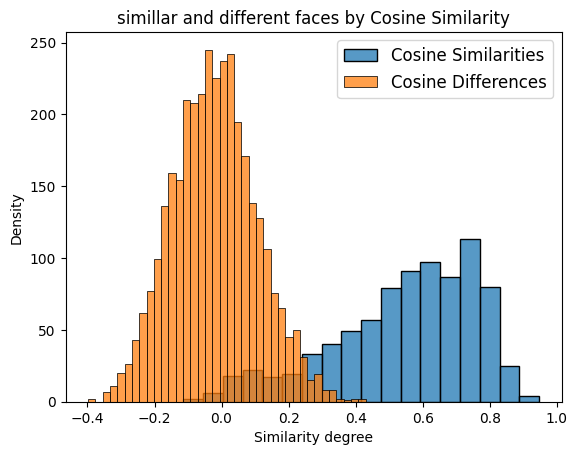

In [20]:
#jvisualization
import seaborn as sns

sns.histplot(cosine_similarities,  kde=False, label='Cosine Similarities')
sns.histplot(cosine_differences,  kde=False,label='Cosine Differences')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('simillar and different faces by Cosine Similarity')
plt.xlabel('Similarity degree')
plt.ylabel('Density')

### training new Cosine similarity dataset with SVM model

In [21]:
cosine_similarities_array = np.array(cosine_similarities)
cosine_differences_array = np.array(cosine_differences)

In [23]:
cosine_similarities_array.shape

(839,)

In [24]:
cosine_differences_array.shape

(3439,)

In [36]:
import random

#create X_train, X_val, Y_train and Y_val for same and different individuals for training in simple mode
cosine_new_dataset_X = np.concatenate((cosine_similarities_array, cosine_differences_array))
cosine_new_dataset_Y = np.concatenate((np.ones(839), np.zeros(3439)))

#shuffle new dataset
#attention: do not split this cell, this shuffelling must run together
random.seed(123)
random.shuffle(cosine_new_dataset_X)
random.seed(123)
random.shuffle(cosine_new_dataset_Y)

cosine_X_train = cosine_new_dataset_X[:3450].reshape(-1, 1)
cosine_X_val = cosine_new_dataset_X[3450:].reshape(-1, 1)

cosine_Y_train = cosine_new_dataset_Y[:3450]
cosine_Y_val = cosine_new_dataset_Y[3450:]

print(f'cosine_X_train : {cosine_X_train.shape}')
print(f'cosine_X_val : {cosine_X_val.shape}')
print(f'cosine_Y_train : {cosine_Y_train.shape}')
print(f'cosine_Y_val : {cosine_Y_val.shape}')

cosine_X_train : (3450, 1)
cosine_X_val : (828, 1)
cosine_Y_train : (3450,)
cosine_Y_val : (828,)


In [37]:
# fit model
SVM_model_simple = SVC(kernel='linear', probability=True)
SVM_model_simple.fit(cosine_X_train, cosine_Y_train)

SVC(kernel='linear', probability=True)

In [38]:
# predict
yhat_train_cosine = SVM_model_simple.predict(cosine_X_train)
yhat_val_cosine = SVM_model_simple.predict(cosine_X_val)
# score
score_train_cosine = accuracy_score(cosine_Y_train, yhat_train_cosine)
score_val_cosine = accuracy_score(cosine_Y_val, yhat_val_cosine)
# summarize
print('Accuracy: train=%.3f, validation=%.3f' % (score_train_cosine*100, score_val_cosine*100))

Accuracy: train=96.928, validation=95.531


### training new simple similarity dataset on SVM model

In [451]:
simple_similarities_array = np.array(simple_similarities)
simple_differences_array = np.array(simple_differences)

In [452]:
simple_similarities_array.shape

(839, 128)

In [453]:
simple_differences_array.shape

(3439, 128)

In [494]:
import random

#create X_train, X_val, Y_train and Y_val for same and different individuals for training in simple mode
new_dataset_X = np.concatenate((simple_similarities_array, simple_differences_array))
new_dataset_Y = np.concatenate((np.ones(839), np.zeros(3439)))

#shuffle new dataset
#attention: do not split this cell, this shuffelling must run together
random.seed(123)
random.shuffle(new_dataset_X)
random.seed(123)
random.shuffle(new_dataset_Y)

simple_X_train = new_dataset_X[:3450]
simple_X_val = new_dataset_X[3450:]

simple_Y_train = new_dataset_Y[:3450]
simple_Y_val = new_dataset_Y[3450:]

print(f'X_train : {simple_X_train.shape}')
print(f'X_val : {simple_X_val.shape}')
print(f'Y_train : {simple_Y_train.shape}')
print(f'Y_val : {simple_Y_val.shape}')

X_train : (3450, 128)
X_val : (828, 128)
Y_train : (3450,)
Y_val : (828,)


##### Training

In [495]:
# normalize input embeding vectors
transformer = Normalizer(norm='l2')
simple_X_train_norm = transformer.transform(simple_X_train)
simple_X_val_norm = transformer.transform(simple_X_val)

In [496]:
# fit model
SVM_model_simple = SVC(kernel='linear', probability=True)
SVM_model_simple.fit(simple_X_train_norm, simple_Y_train)

SVC(kernel='linear', probability=True)

In [497]:
# predict
yhat_train_simple = SVM_model_simple.predict(simple_X_train_norm)
yhat_val_simple = SVM_model_simple.predict(simple_X_val_norm)
# score
score_train_simple = accuracy_score(simple_Y_train, yhat_train_simple)
score_val_simple = accuracy_score(simple_Y_val, yhat_val_simple)
# summarize
print('Accuracy: train=%.3f, validation=%.3f' % (score_train_simple*100, score_val_simple*100))

Accuracy: train=80.899, validation=78.261


##### Visualization of norm 2 and actual values after applying simple diffrentiate

Text(0, 0.5, 'Density')

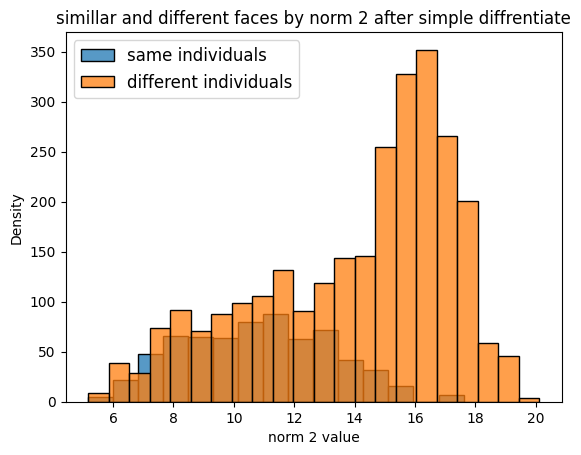

In [478]:
sns.histplot(np.linalg.norm(simple_X_train[np.where(simple_Y_train == 1)[0]], axis=1), kde=False, label='same individuals')
sns.histplot(np.linalg.norm(simple_X_train[np.where(simple_Y_train == 0)[0]], axis=1), kde=False, label='different individuals')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('simillar and different faces by norm 2 after simple diffrentiate')
plt.xlabel('norm 2 value')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

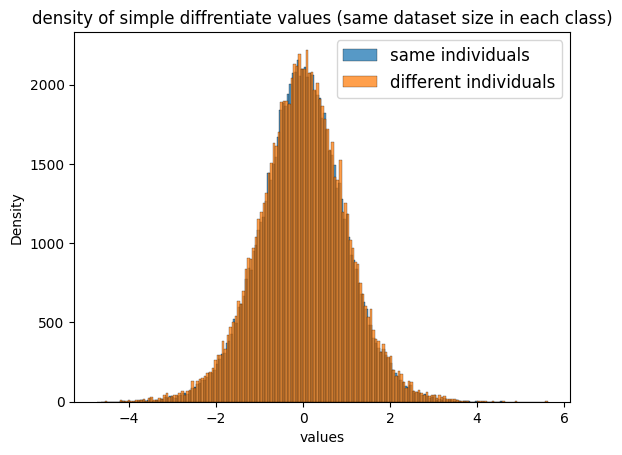

In [492]:
sns.histplot(simple_X_train[np.where(simple_Y_train == 1)[0]].reshape(-1), kde=False, label='same individuals')
sns.histplot(simple_X_train[np.where(simple_Y_train == 0)[0]].reshape(-1)[:85760], kde=False, label='different individuals')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('density of simple diffrentiate values (same dataset size in each class)')
plt.xlabel('values')
plt.ylabel('Density')